In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-white')

%matplotlib inline

# Probability Functions

These functions determine the probability of various events, and use them to compute the expected number of values given a certain number of rolls.

In [2]:
def fate_probability(value):
    """Returns the probability of rolling a value on 4dF.

    Args:
        value (int): The value rolled on 4dF.

    Returns:
        float: The probability of rolling the value, that is P(4dF=value).

    Raises:
        TypeError: If -4 <= value <= 4 and value is not an integer.

    """
    # Outside bounds
    if not -4 <= value <= 4:
        return 0

    # The probability of rolling a sum of 0, 1, 2, 3, 4 (negatives are same probability)
    probability = [19/81, 16/81, 10/81, 4/81, 1/81]

    return probability[abs(value)]

In [3]:
def configuration_probability(value, n_times, m_tries):
    """ Give the probability of rolling a value exactly N times on 4dF, given M
    rolls.

    The formula for the probability is:

    (M choose N) * P(Value)^N * P(Not Value)^{M-N}

    Where (M choose N) is the binomial coefficient, P(Value)^N is the
    probability of rolling the value exactly N times, and P(Not Value)^{M-N} is
    the probability of rolling any other result M-N times.

    Args:
        value (int): The value rolled on 4dF.
        n_times (int): The number of times the value should appear.
        m_tries (int): The total number of 4dF rolls.

    Returns:
        float: The probability of the desired combination.
    """
    # Binomial coefficient
    coeff = math.factorial(m_tries) // (math.factorial(n_times) * math.factorial(m_tries - n_times))
    p = fate_probability(value)

    total_probability = coeff * (p**n_times) * ((1-p)**(m_tries-n_times))

    return total_probability

In [4]:
def get_interval(m_tries, start=0.025, end=0.975):
    """Find the lower and upper bounds on the number of times 4dF should roll a
    certain value given m total rolls.

    The lower bound is defined as n + 0.5 such that CP(n) < start < CP(n+1).
    The upper bound is defined as n + 0.5 such that CP(n) < end < CP(n+1)

    CP(n) is the cumulative probability, such that:

        CP(n) = Sum of P(i) for 0 <= i <= n

    Args:
        m_tries (int): The total number of 4dF rolls.

    Returns:
        array of tuples: An array of tuples for the lower and upper bounds
            expected for rolling values -4, -3, -2, -1, 0, 1, 2, 3, 4 on 4dF
            rolled m times. The array has the following form:

            [
                (lower, upper), # Bounds for number of -4s expected
                (lower, upper), # Bounds for number of -3s expected
                ...
                (lower, upper), # Bounds for number of 4s expected
            ]
    """
    output = []
    # Check each 4dF value
    for val in range(-4, 5):
        lower = None
        upper = None
        total_probability = 0

        # Check all possible number of results we could get
        for n in range(m_tries+1):
            total_probability += configuration_probability(val, n, m_tries)
            if total_probability > start and lower is None:
                lower = n - 0.5
            elif total_probability > end and upper is None:
                upper = n - 0.5
                break

        output.append((lower, upper))
    return output

# Read the data

The data is, unfortunately, recorded like this:

`date, black_roll, blue_roll, red_roll, white_roll`

With dates repeated, and empty values if a set of dice was rolled fewer times that night than the others that night. I would much prefer something like:

`date, color, Result`

So I melt the dataframe and rearrange it. I use `dropna()` to remove the empty values for `Result` or `Color`, but not for `Date` (some days were not recorded, but we only care about the rolls).

In [5]:
df = pd.read_csv("./fate_dice_data.csv")
df = pd.melt(df, id_vars="Date", var_name="Color", value_name="Result").dropna(subset=["Result", "Color"])

In [6]:
# Plot size
WIDTH = 10
HEIGHT = 10

# Bins edges
BINS = [-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]

# Colors from Seaborn
RED, BLUE, GREEN, PURPLE = sns.color_palette("Set1", 4)

# A map of plot colors to dice colors. This also sets the order in which they are plotted.
COLORS = (
    ("Blue", BLUE),
    ("Black", PURPLE),
    ("Red", RED),
    ("White", GREEN),
)

# Set the Z ordering of elements on the plot. Items with a larger order will overlay lower order items.
GREY_HIST_Z = 0
WHITE_HIST_Z = 1
POINTS_Z = 2
ANNOTATION_Z = 3

# Set the interval
START_INTERVAL = 0.005
END_INTERVAL = 1 - START_INTERVAL

# A single event per bin, used for drawing the contours which use weights to set the value of each bin
FAKE_COUNTS = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

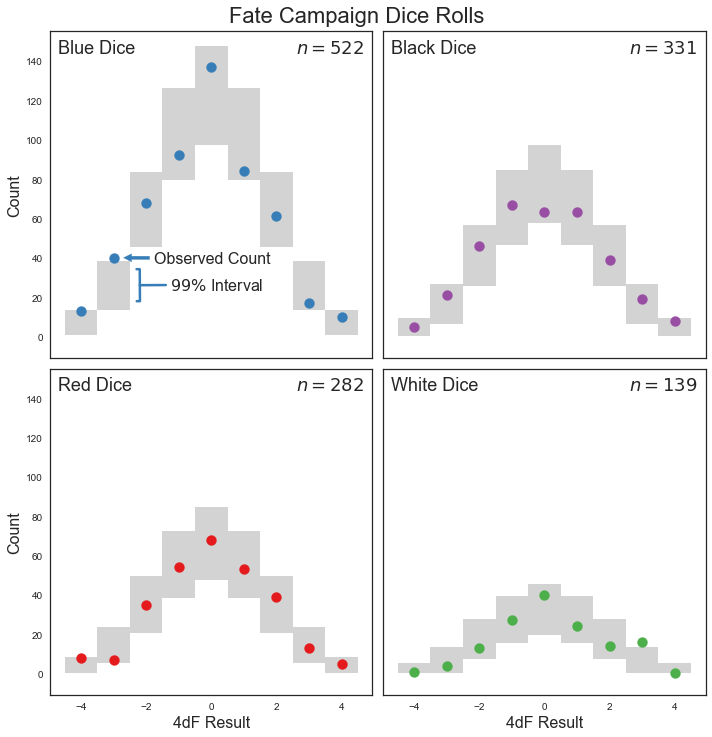

In [7]:
# Set the canvas size
fig = plt.figure(figsize=(WIDTH, HEIGHT))

plot_number = 0
first_ax = None
for name, hist_color in COLORS:
    plot_number += 1
    ax = plt.subplot(2, 2, plot_number)

    # Save the first ax and use it to sharex and sharey
    if first_ax is None:
        first_ax = ax
    ax = plt.subplot(2, 2, plot_number, sharex=first_ax, sharey=first_ax)

    # Make the top plots have invisible X ticks and labels
    if plot_number <= 2:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.set_xlabel("4dF Result", size=16)

    # Make the right plots have invisible Y ticks and labels
    if plot_number in (2, 4):
        plt.setp(ax.get_yticklabels(), visible=False)
    else:
        ax.set_ylabel("Count", size=16)

    # Plot the observed points
    sub_df = df[df["Color" ] == name]
    sub_array = np.array(sub_df["Result"])
    counts = np.histogram(sub_array, bins=BINS)[0]
    plt.scatter(y=counts, x=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color=hist_color, s=100, zorder=POINTS_Z)

    # We plot "confidence intervals" calculated by finding the point at which
    # the cumulative probability of rolling a configuration of dice crosses a
    # critical threshold. The white histogram is used to cover up the bottom of
    # the grey histogram, giving an appearance of ranges.
    lowers, uppers = zip(*get_interval(len(sub_array), start=START_INTERVAL, end=END_INTERVAL))
    plt.hist(
        FAKE_COUNTS,
        bins=BINS,
        color="white",
        weights=lowers,
        linewidth=2.5,
        zorder=WHITE_HIST_Z,
    )
    plt.hist(
        FAKE_COUNTS,
        bins=BINS,
        color="lightgrey",
        weights=uppers,
        linewidth=2.5,
        zorder=GREY_HIST_Z,
    )

    # Annotate the first plot
    if plot_number == 1:
        count_arrow = {
            "arrowstyle": "simple",
            "connectionstyle": "arc3",
            "color": hist_color,
            "shrinkB": 10,
        }
        ax.annotate(
            "Observed Count",
            (-3, 40),
            xytext=(40, -5),
            textcoords='offset points',
            arrowprops=count_arrow,
            size=16,
            zorder=ANNOTATION_Z,
        )

        interval_arrow = {
            "arrowstyle": "-[",
            "connectionstyle": "arc3",
            "color": hist_color,
            "shrinkB": 10,
            "linewidth": 2.5,
        }
        ax.annotate(
            "$99\%$ Interval",
            (-2.5, (17+35)/2),
            xytext=(40, -5),
            textcoords='offset points',
            arrowprops=interval_arrow,
            size=16,
            zorder=ANNOTATION_Z,
        )

    # Add a label to the plot about the dice
    Y_POS = 144
    plt.text(-4.7, Y_POS, "{color} Dice".format(color=name), size=18)
    plt.text(2.6, Y_POS, "$n={n}$".format(n=len(sub_array)), size=18)

# Set main title
plt.suptitle('Fate Campaign Dice Rolls', y=1.02, fontsize=22)

# Make the plots move together
plt.tight_layout()

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/fate_dice_rolls.{ext}".format(ext=ext), bbox_inches="tight")

# $\chi^2$ Test

Finally, we check the results with a $\chi^2$ test.

In [8]:
def expected_array(arr):
    """ Compute the expected values for each bin given a series of 4dF rolls.

    Args:
        arr (list): A list of the rolls recorded, where arr[0] is the number of
            -4s seen, and arr[8] is the number of +4s seen.

    Returns:
        list: A list of expected number of rolls seen by value.

    """
    n = sum(arr)

    result = []
    for value in range(-4, 5):
        exp = fate_probability(value) * n
        result.append(exp)

    return result

In [9]:
# Calculate the Chi2 for each set of dice, compared to the expected value for fair dice
for name in ("Blue", "Black", "Red", "White"):
    print(name)
    
    sub_df = df[df["Color" ] == name]
    sub_array = np.array(sub_df["Result"])
    counts = np.histogram(sub_array, bins=BINS)[0]
    
    exp_counts = expected_array(counts)
    chi, p = stats.chisquare(counts, exp_counts)
    print("The statistic is {} and the p-value is {}".format(chi, p), end="\n\n")

Blue
The statistic is 26.316016333938293 and the p-value is 0.0009271670473685792

Black
The statistic is 9.327186357131502 and the p-value is 0.31545111294692785

Red
The statistic is 10.772179451287796 and the p-value is 0.21494494890401578

White
The statistic is 19.079964975388116 and the p-value is 0.014437794633536498

